LSTM을 이용해 네이버 영화 리뷰를 분류해보자.  

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Mecab
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter 

### 1) 데이터 로드하기

위 링크로부터  
훈련 데이터에 해당하는 ratings_train.txt와   
테스트 데이터에 해당하는 ratings_test.txt를 다운로드한다.

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x1617fa51ac0>)

pandas를 이용하여  
훈련 데이터는 train_data,
테스트 데이터는 test_data에 저장한다.  

In [3]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

train_data에 존재하는 영화 리뷰의 개수를 확인해보자.  

In [4]:
print('훈련용 리뷰 개수 :', len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


train_data는 총 150,000개의 리뷰가 존재한다.  
상위 5개의 샘플을 출력해보자. 

In [5]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


해당 데이터는 id, document, label 총 3개의 열로 구성되어있다.  

In [6]:
print('테스트용 리뷰 개수 : ', len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 :  50000


test_data는 총 50,000개의 영화 리뷰가 존재한다.  
상위 5개의 샘플을 출력해보자.  

In [7]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


역시 id, document, label 총 3개의 열로 구성되어있다.  

### 2) 데이터 정제하기

train_data의 데이터 중복 유무를 확인하자.

In [8]:
# document 열과 laber 열의 중복을 제외한 값의 개수

# .nunique() : Count number of distinct elements in specified axis. 중복값 찾는 메소드
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

150,000 - 146182 = 즉, 약 4,000개의 중복 샘플을 확인했다.

In [9]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [10]:
print('총 샘플의 수 : ', len(train_data))

총 샘플의 수 :  146183


이제 train_dat에서 해당 리뷰의 긍, 부정 유무가 기재되어 있는 label 값의 분포를 보자. 

<Axes: xlabel='label'>

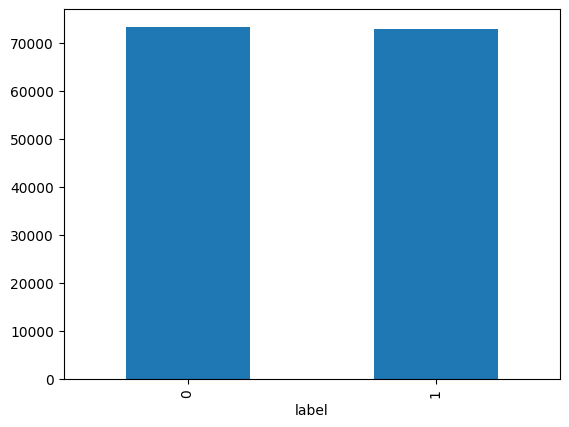

In [11]:
train_data['label'] .value_counts().plot(kind = 'bar')

In [16]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  73342
1      1  72841


리뷰 중에 Null 값을 갖는 샘플이 있는지 확인하자.  

In [18]:
print(train_data.isnull().values.any())

True


True가 나왔다면 데이터 중에 Null 값을 가진 샘플이 존재한다는 뜻이다.  
어떤 열에 존재하는지 확인해보자.  

In [19]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


리뷰가 적혀있는 document 열에서 Null 값을 가진 샘플이 총 1개가 존재한다.  
그렇다면 document 열에서 Null 값이 존재한다는 것을 조건으로 Null 값을 가진 샘플이 어느 인덱스의 위치에 존재하는지 한 번 출력해보자.

In [20]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


Null 값을 제거하자.

In [21]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [22]:
print(len(train_data))

146182


데이터 전처리

In [24]:
#알파벳과 공백을 제외하고 모두 제거
eng_text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
print(re.sub(r'[^a-zA-Z ]', '', eng_text))

do you expect people to read the FAQ etc and actually accept hard atheism


In [25]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data[:5]


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


train_data에 공백(whitespace)만 있거나 빈 값을 가진 행이 있다면 Null 값으로 변경하도록 하고,   
Null 값이 존재하는지 확인해보자.

In [28]:
train_data['document'] = train_data['document'].str.replace('^ +', "", regex=True) # white space 데이터를 empty value로 변경
train_data.replace({'document':''}, np.nan, inplace=True)
print(train_data.isnull().sum())


id            0
document    789
label         0
dtype: int64


In [29]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [ ]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [34]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "", regex=True) # 공백은 empty 값으로 변경
test_data.replace({'document':''}, np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))


전처리 후 테스트용 샘플의 개수 : 48389


### 3) 토큰화

In [35]:
# 불용어 지정
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [39]:
mecab = Mecab()
mecab.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔')

Exception: Install MeCab in order to use it: http://konlpy.org/en/latest/install/